[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2012-05-18 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, META)  2923 non-null   float64
 1   (Close, META)      2923 non-null   float64
 2   (High, META)       2923 non-null   float64
 3   (Low, META)        2923 non-null   float64
 4   (Open, META)       2923 non-null   float64
 5   (Volume, META)     2923 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 159.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6080 entries, 1999-11-01 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, MSFT)  6080 non-null   float64
 1   (Close, MSFT)      6080 non-null   float64
 2   (High, MSFT)       6080 non-null   float64
 3   (Low, MSFT)

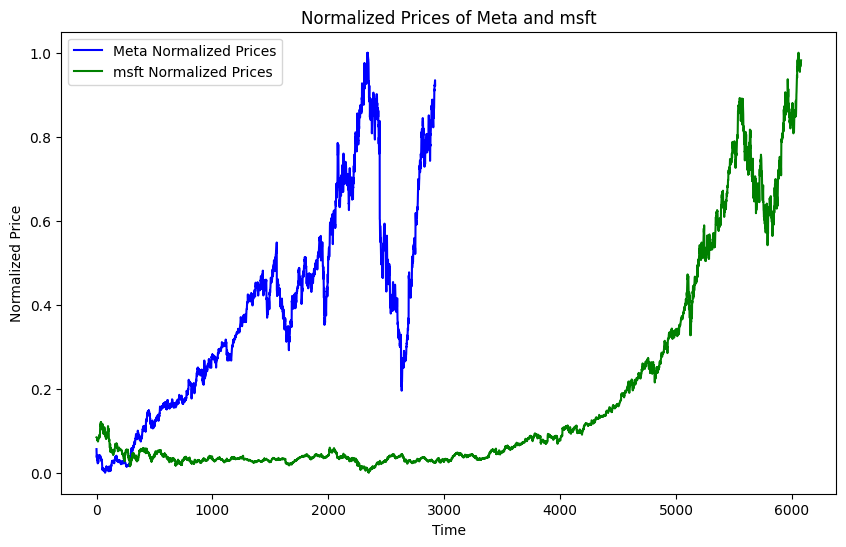

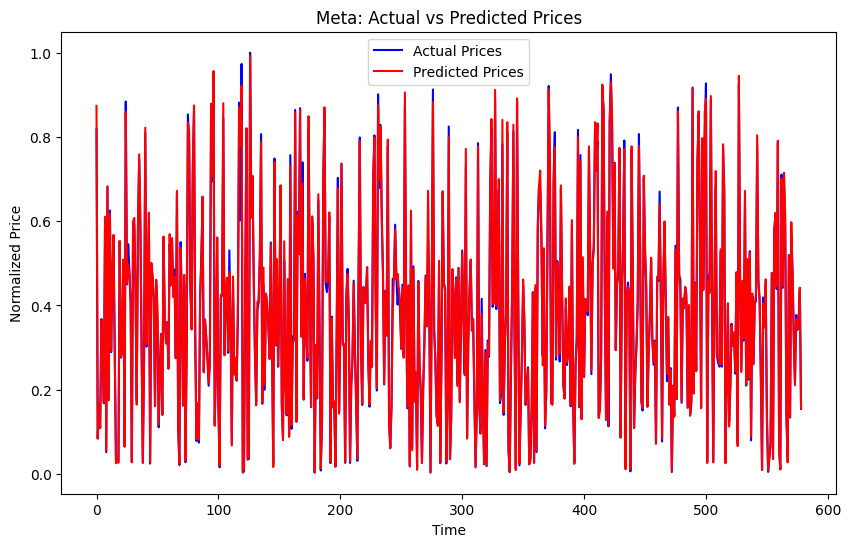

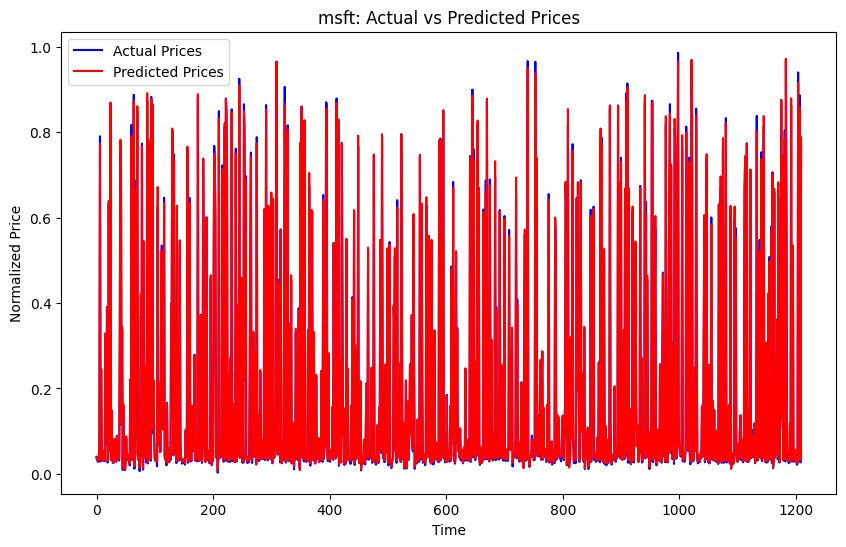

Meta RMSE: 0.017275880303690944
Meta MAE: 0.010023247310267509
Meta MAPE: [0.00029846]
Meta F1 Score: 0.9773462783171522
msft RMSE: 0.008091928355555273
msft MAE: 0.0049924868708631324
msft MAPE: [6.54793045e-05]
msft F1 Score: 0.9974683544303797


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Fetch Meta and msft (MSFT) data
meta_data = yf.download('META', start='1999-11-01', end='2024-01-01')
msft_data = yf.download('MSFT', start='1999-11-01', end='2024-01-01')

# Display basic information about the datasets
meta_data.info()
msft_data.info()

# Preprocess Data: Closing prices
meta_prices = meta_data['Close'].values.reshape(-1, 1)
msft_prices = msft_data['Close'].values.reshape(-1, 1)

# Normalize Data
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

meta_prices_norm = normalize(meta_prices)
msft_prices_norm = normalize(msft_prices)

# Prepare Dataset
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

X_meta, y_meta = create_dataset(meta_prices_norm)
X_msft, y_msft = create_dataset(msft_prices_norm)

# Split Data into Training and Test sets
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_meta, y_meta, test_size=0.2)
X_msft_train, X_msft_test, y_msft_train, y_msft_test = train_test_split(X_msft, y_msft, test_size=0.2)

# LSTM Model Definition
def build_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(30, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train Model
lstm_model_meta = build_lstm_model()
history_meta = lstm_model_meta.fit(X_meta_train, y_meta_train, epochs=50, batch_size=64, validation_data=(X_meta_test, y_meta_test))

lstm_model_msft = build_lstm_model()
history_msft = lstm_model_msft.fit(X_msft_train, y_msft_train, epochs=50, batch_size=64, validation_data=(X_msft_test, y_msft_test))

# Evaluate and Predict
meta_predictions = lstm_model_meta.predict(X_meta_test)
msft_predictions = lstm_model_msft.predict(X_msft_test)

# Plot normalized prices before training
def plot_normalized_data(meta_norm, msft_norm):
    plt.figure(figsize=(10, 6))
    plt.plot(meta_norm, label='Meta Normalized Prices', color='blue')
    plt.plot(msft_norm, label='msft Normalized Prices', color='green')
    plt.title('Normalized Prices of Meta and msft')
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

plot_normalized_data(meta_prices_norm, msft_prices_norm)

# Plot actual vs. predicted prices for Meta
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predicted, color='red', label='Predicted Prices')
    plt.title(f'{title}: Actual vs Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()
    # plt.figure(figsize = (18,9))
    # plt.plot(range(X_test.shape[0]),y_test,color='b',label='True')
    # plt.plot(range(X_test.shape[0]),y_pred,color='orange',label='Prediction')
    # plt.xlabel('Date')
    # plt.ylabel('Mid Price')
    # plt.legend(fontsize=18)
    # plt.show()


plot_predictions(y_meta_test, meta_predictions, 'Meta')
plot_predictions(y_msft_test, msft_predictions, 'msft')

# Calculate RMSE and MAPE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mse(y_true, y_pred):
    # Check if both lists have the same length
    if len(y_true) != len(y_pred):
        raise ValueError("The length of y_true and y_pred must be the same.")
    
    # Calculate the mean squared error
    mse = sum((true - pred) ** 2 for true, pred in zip(y_true, y_pred)) / len(y_true)
    
    return mse

def calculate_f1(y_true, y_pred):
    # Convert predictions back to the original scale
    y_true_rounded = np.round(y_true)
    y_pred_rounded = np.round(y_pred)

    true_positives = np.sum((y_true_rounded == 1) & (y_pred_rounded == 1))
    false_positives = np.sum((y_true_rounded == 0) & (y_pred_rounded == 1))
    false_negatives = np.sum((y_true_rounded == 1) & (y_pred_rounded == 0))

    if true_positives == 0:
        return 0.0  # To avoid division by zero

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

# Calculate metrics for Meta
rmse_meta = calculate_rmse(y_meta_test, meta_predictions)
mae_meta = calculate_mae(y_meta_test, meta_predictions)
mape_meta = calculate_mse(y_meta_test, meta_predictions)
f1_meta = calculate_f1(y_meta_test, meta_predictions)

# Calculate metrics for msft
rmse_msft = calculate_rmse(y_msft_test, msft_predictions)
mae_msft = calculate_mae(y_msft_test, msft_predictions)
mape_msft = calculate_mse(y_msft_test, msft_predictions)
f1_msft = calculate_f1(y_msft_test, msft_predictions)

# Print evaluation metrics
print(f"Meta RMSE: {rmse_meta}")
print(f"Meta MAE: {mae_meta}")
print(f"Meta MAPE: {mape_meta}")
print(f"Meta F1 Score: {f1_meta}")

print(f"msft RMSE: {rmse_msft}")
print(f"msft MAE: {mae_msft}")
print(f"msft MAPE: {mape_msft}")
print(f"msft F1 Score: {f1_msft}")


In [2]:
# Export


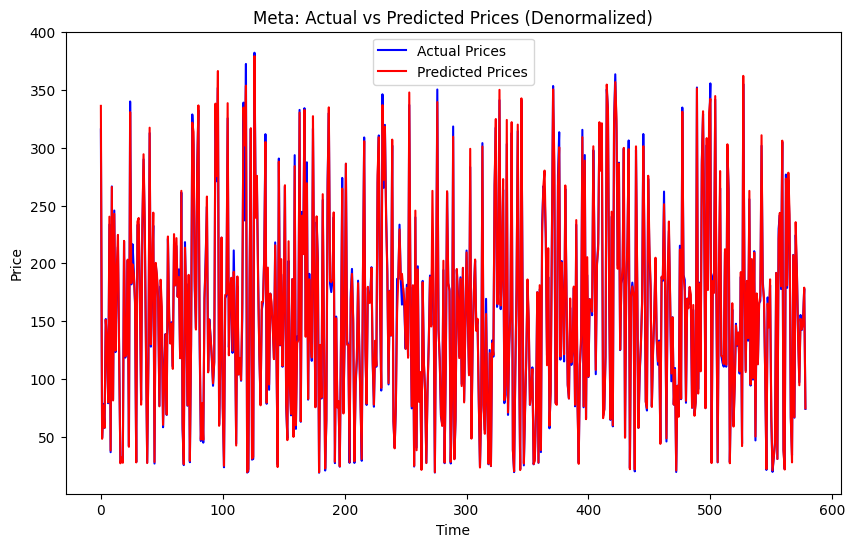

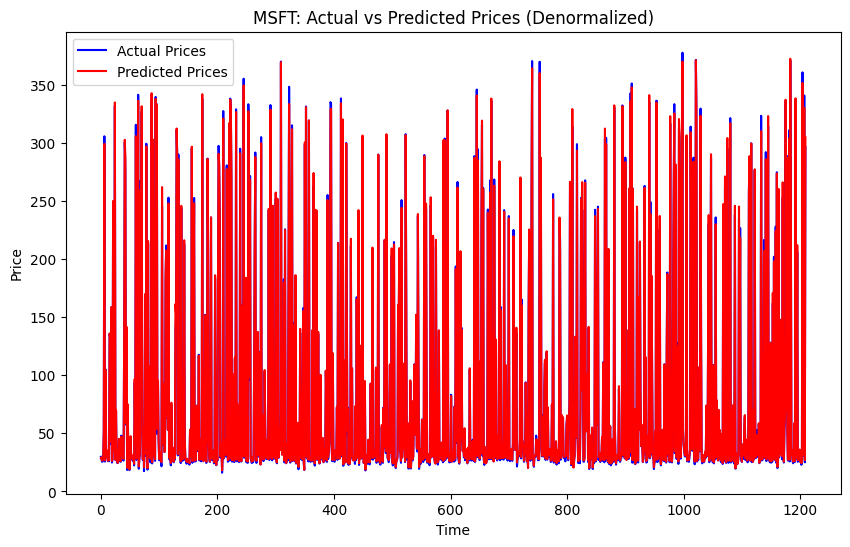

In [7]:
def plot_denormalized_predictions(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predicted, color='red', label='Predicted Prices')
    plt.title(f'{title}: Actual vs Predicted Prices (Denormalized)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


def denormalize(normalized_data, original_data):
    data_min = np.min(original_data)
    data_max = np.max(original_data)
    return normalized_data * (data_max - data_min) + data_min

# Denormalize Meta predictions
meta_predictions_denorm = denormalize(meta_predictions, meta_prices)

# Denormalize MSFT predictions
msft_predictions_denorm = denormalize(msft_predictions, msft_prices)

# Similarly, you can denormalize the actual test values for comparison:
y_meta_test_denorm = denormalize(y_meta_test, meta_prices)
y_msft_test_denorm = denormalize(y_msft_test, msft_prices)

# Plot for Meta
plot_denormalized_predictions(y_meta_test_denorm, meta_predictions_denorm, 'Meta')

# Plot for MSFT
plot_denormalized_predictions(y_msft_test_denorm, msft_predictions_denorm, 'MSFT')


# The next three years

In [22]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 3 years of META stock data (252 trading days per year)
data = yf.download('META', period='2y', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Ensure the input data size matches the model's expectations
# Prepare the current batch (60 most recent days)
current_batch = scaled_data[-360:].reshape((1, 360, 1))  # Correcting the shape

# Predict for 3 years (about 756 trading days)
predicted_prices = []
days_to_predict = 3 * 252  # Approximate trading days in 3 years

for i in range(days_to_predict):
    # Get the prediction (next day)
    next_prediction = lstm_model_meta.predict(current_batch)

    # Ensure the prediction is reshaped correctly before adding it to the batch
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print(f"Predicted Stock Prices for the next {days_to_predict} days (3 years):", predicted_prices)

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

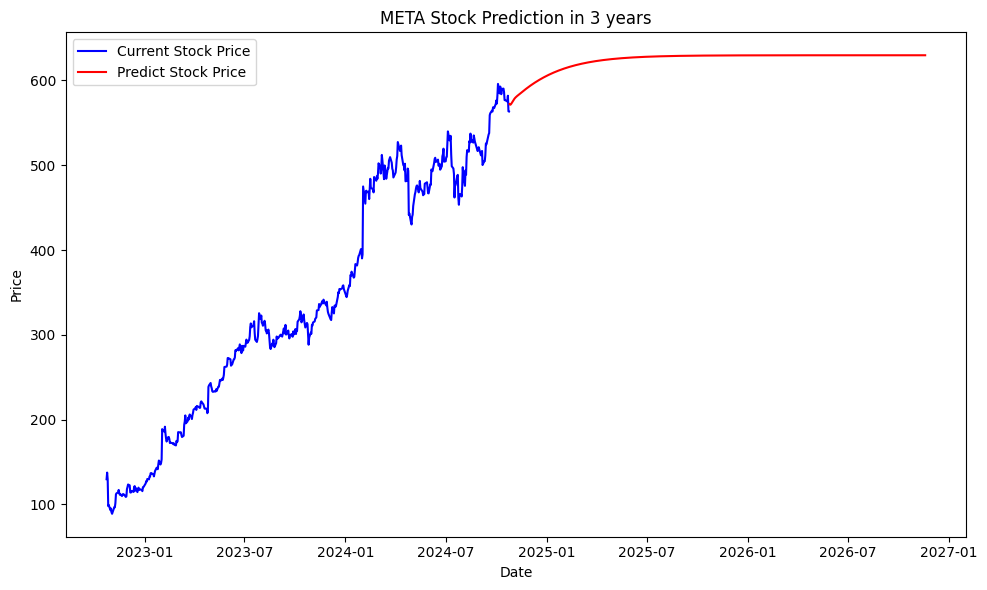

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten multi-level columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]


# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=756)

# Assuming 'predicted_prices' is your list of predicted prices for the next 3 years
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Assuming df1 and df2 are your two DataFrames with prices and index as date
# df1 is the first DataFrame, and df2 is the continuation

# Plot df1
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close_META'], label='Current Stock Price', color='blue')

# Plot df2 with a different color
plt.plot(predictions_df.index, predictions_df['Close'], label='Predict Stock Price', color='red')

# Adding labels and title
plt.xlabel("Date")
plt.ylabel("Price")

# Add a legend to differentiate between the two DataFrames
plt.legend()
plt.title("META Stock Prediction in 3 years")

# Show the plot
plt.tight_layout()
plt.show()